In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tardis import *
from scipy import sparse,ndimage
from scipy.stats import gaussian_kde
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn import linear_model
import time
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0


Using TensorFlow backend.


Running TARDIS 2.1...


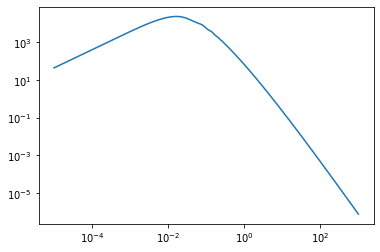

In [3]:
klin = np.loadtxt('Planck15_a1p00.txt').T[0]
plin = np.loadtxt('Planck15_a1p00.txt').T[1]
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [23]:
n=128
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni.evolv() #run the simulation

(128, 128, 128)
2097152 65 2097152
Total run time 28.91370439529419


# Reconstruct with a constant field

In [24]:
uni.final_tau_RSD=ones(shape=(1,n,n,n))

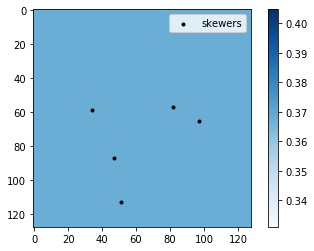

In [27]:
n_los = 5
mock_lya = lya_survey(uni,50,50,sm=0.5,n_skewers=n_los)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

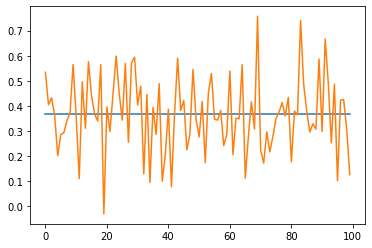

In [28]:
plot(mock_lya.vals_lya[:100])
plot(mock_lya.vals_observed[:100])
# ylim(0.35,0.385)

In [29]:
def chi(inputs, data, inverse_covar):

    residual = tf.subtract(inputs, data)
    a = tf.sparse.sparse_dense_matmul(inverse_covar, residual,adjoint_b=True)
    value = tf.matmul(residual,a)
    return value

def overone(flux):

    flux = K.clip(flux,1,None)
    return(tf.reduce_sum(flux))

def nodes(flux):

    flux = K.clip(flux,0,0.4)
    return(tf.reduce_sum(flux))
#The final loss functon we want to minimize

tf.compat.v1.reset_default_graph()
lya = mock_lya
anneal_steps=[2.5,2]
# anneal_steps=[2.5,1]
k=[6,6,0.4,0.1]
nc = n
bs = n
gtol=1e-5/512
maxiter=[50,50,60,30,100]
kvec = fftk((nc,nc,nc), symmetric=False)
kmesh = sum((np.array(kvec,dtype=object))**2)**0.5
pkmesh = ipklin(kmesh)

RSD_tau=tf.Variable(np.zeros(shape=(1,nc,nc,nc)),dtype='float32',trainable=True)



Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')

sum_op = reduce_sum_det
Rsm = tf.multiply(Rs, 1)

flux = tf.exp(-RSD_tau)
flux_s = smoothing(flux,Rsm,kmesh,nc)
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
flux_val = flowpm.cic_readout(flux,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
            +k[2]*overone(flux)+k[3]*nodes(flux))

sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())

time_start = time.time()
for nn,r0 in enumerate(anneal_steps):
    opt = ScipyOptimizerInterface(obj_fun, var_list=[RSD_tau], method='L-BFGS-B',
                                       options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})

    z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_RSD_tau,recon_flux,flux_out = sess.run([RSD_tau,flux_val,flux],{yy_lya:lya.vals_observed})
jac = opt.result.jac.reshape(n,n,n)


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 5544463.000000
  Number of iterations: 34
  Number of functions evaluations: 63
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5542570.500000
  Number of iterations: 50
  Number of functions evaluations: 82
Total run time 33.327226


In [30]:
d_f = zeros([n,n])
t1 = time.time()
# RSD_tau_tf = tf.placeholder(tf.float32, shape = [1,n,n,n])
flux = tf.placeholder(tf.float32, shape = [1,n,n,n])
flux_s = smoothing(flux,Rsm,kmesh,nc)
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun2 = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
                    +k[2]*overone(flux)+k[3]*nodes(flux))
sess.run(tf.compat.v1.global_variables_initializer())
flux_recon = exp(-recon_RSD_tau)
loss_0 = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0.7],flux:flux_recon})[0][0]
for i in range(n):
    for j in range(n):
        flux_d = flux_recon.copy()
        flux_d[0][i,j,0] = flux_d[0][i,j,0]+0.1
        a = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0.7],flux:flux_d})
        print('\r'+str(time.time()-t1),end=' ')
        d_f[i,j]=a[0][0]
d_f = d_f-loss_0

361.4075357913971  

Text(0.5, 0.98, 'Constant field')

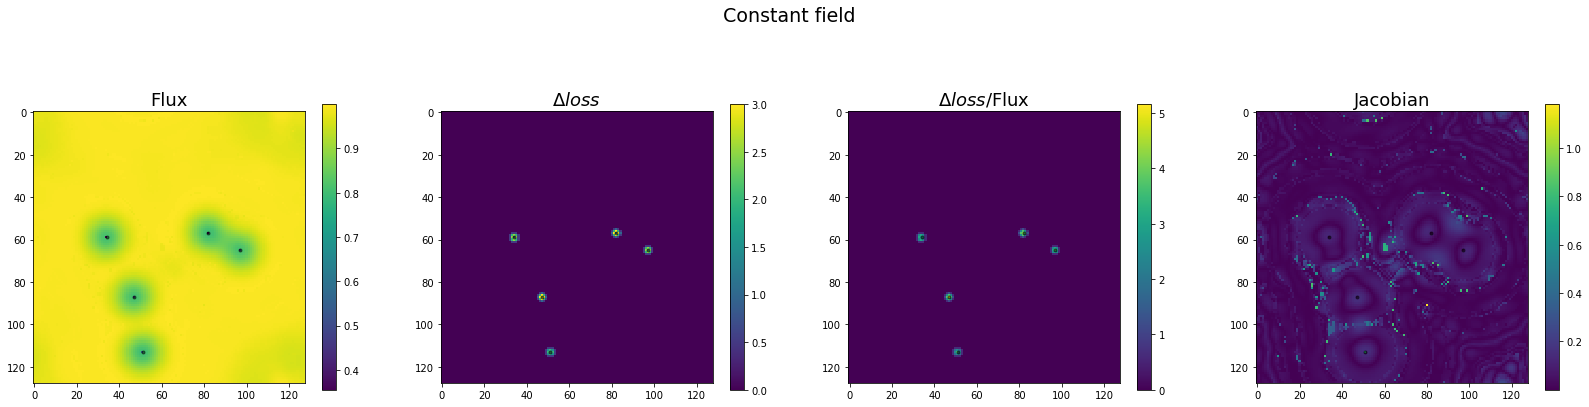

In [63]:
figure(figsize=(28,7))
subplot(141)
imshow(exp(-recon_RSD_tau[0,...,0]).T)
colorbar(shrink=0.75)
title('Flux',fontsize=18)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(142)
imshow(abs(d_f).T)
title(r'$\Delta loss$',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(143)
imshow((abs(d_f)/exp(-recon_RSD_tau[0,...,0])).T)
title(r'$\Delta loss$/Flux',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(144)
imshow(abs(jac[:,:,0].T))
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title('Jacobian',fontsize=18)
suptitle('Constant field',fontsize=19)

# Reconstruct with a true field

In [35]:
n=128
uni2 = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin )
uni2.evolv() #run the simulation

(128, 128, 128)
2097152 65 2097152
Total run time 28.159207344055176


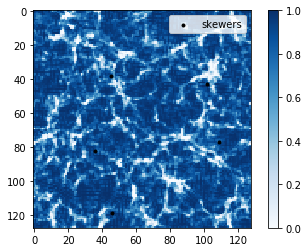

In [44]:
n_los = 5
mock_lya2 = lya_survey(uni2,50,50,sm=0.5,n_skewers=n_los)
mock_lya2.select_skewers()
imshow(np.exp(-1*uni2.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya2.skewers_fin[::n][:,0],mock_lya2.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

In [46]:
tf.compat.v1.reset_default_graph()
lya = mock_lya2
anneal_steps=[2.5,2]
k=[6,6,0.4,0.1]
nc = n
bs = n
gtol=1e-5/512
maxiter=[20,20,60,30,100]
kvec = fftk((nc,nc,nc), symmetric=False)
kmesh = sum((np.array(kvec,dtype=object))**2)**0.5
pkmesh = ipklin(kmesh)

RSD_tau=tf.Variable(np.zeros(shape=(1,nc,nc,nc)),dtype='float32',trainable=True)



Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')

sum_op = reduce_sum_det
Rsm = tf.multiply(Rs, 1)

flux = tf.exp(-RSD_tau)
flux_s = smoothing(flux,Rsm,kmesh,nc)
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
flux_val = flowpm.cic_readout(flux,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
            +k[2]*overone(flux)+k[3]*nodes(flux))

sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())

time_start = time.time()
for nn,r0 in enumerate(anneal_steps):
    opt = ScipyOptimizerInterface(obj_fun, var_list=[RSD_tau], method='L-BFGS-B',
                                       options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})

    z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_RSD_tau2,recon_flux2,flux_out2 = sess.run([RSD_tau,flux_val,flux],{yy_lya:lya.vals_observed})
jac2 = opt.result.jac.reshape(n,n,n)


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5538202.000000
  Number of iterations: 20
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 5538090.000000
  Number of iterations: 20
  Number of functions evaluations: 24
Total run time 13.768804


In [51]:
d_f2 = zeros([n,n])
t1 = time.time()
flux = tf.placeholder(tf.float32, shape = [1,n,n,n])
flux_s = smoothing(flux,Rsm,kmesh,nc)
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))
obj_fun2 = k[0]*(chi(flux_val,yy_lya,lya.inverse_covar)+k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
                    +k[2]*overone(flux)+k[3]*nodes(flux))
sess.run(tf.compat.v1.global_variables_initializer())
flux_recon = exp(-recon_RSD_tau2)
loss_0 = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0.7],flux:flux_recon})[0][0]
for i in range(n):
    for j in range(n):
        flux_d = flux_recon.copy()
        flux_d[0][i,j,16] = flux_d[0][i,j,16]-1
        a = sess.run(obj_fun2,{yy_lya:lya.vals_observed,Rs:[0.7],flux:flux_d})
        print('\r'+str(time.time()-t1),end=' ')
        d_f2[i,j]=a[0][0]
d_f2 = d_f2-loss_0

348.198059797287   

Text(0.5, 1.0, 'Jacobian')

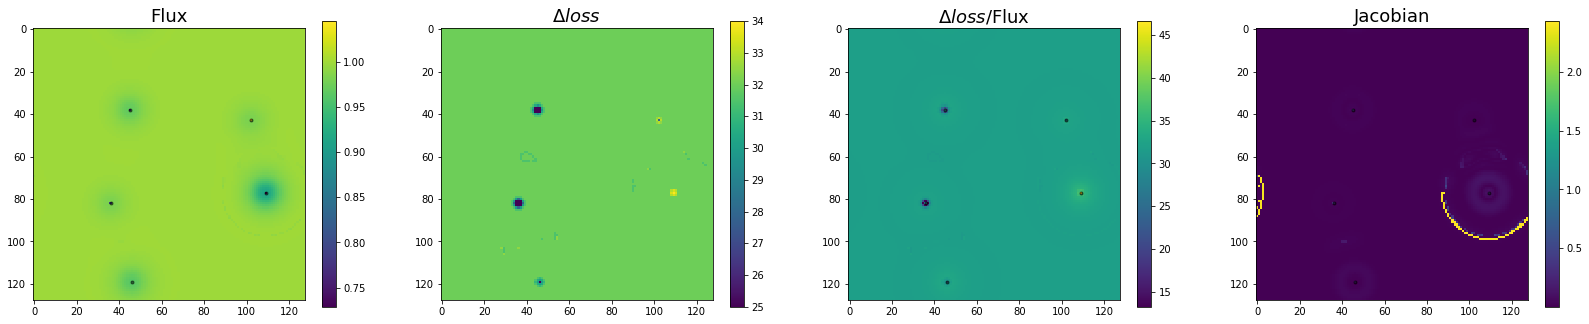

In [60]:
figure(figsize=(28,7))
subplot(141)
imshow(exp(-recon_RSD_tau2[0,...,0]).T)
colorbar(shrink=0.75)
title('Flux',fontsize=18)
plt.scatter(mock_lya2.skewers_fin[::n][:,0],mock_lya2.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(142)
imshow(abs(d_f2).T,vmin=25)
title(r'$\Delta loss$',fontsize=18)
colorbar(shrink=0.75)
# plt.scatter(mock_lya2.skewers_fin[::n][:,0],mock_lya2.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(143)
imshow((abs(d_f2)/exp(-recon_RSD_tau2[0,...,0])).T)
title(r'$\Delta loss$/Flux',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya2.skewers_fin[::n][:,0],mock_lya2.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(144)
imshow(abs(jac2[:,:,0].T))
colorbar(shrink=0.75)
plt.scatter(mock_lya2.skewers_fin[::n][:,0],mock_lya2.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title('Jacobian',fontsize=18)